# SpikeShip - Demo

Application of SpikeShip algorithm using simulated data from the work made by Grossberger et al. (2018) https://github.com/LGro/spot/blob/master/notebooks/SPOTDisClust_Demo.ipynb.


In [1]:
import numpy as np
from spot import spot, tools
from spikeship import spikeship, tools
import matplotlib.pylab as plt

# warnings from jupyter notebook
import warnings
warnings.filterwarnings('ignore')

c:\Users\bsoto\anaconda3\envs\spikeship\lib\site-packages\numba\core\decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


### Reading data sources

In [2]:
spike_times    = np.load('../spotdis_example_data/spike_times_example.npy')
ii_spike_times = np.load('../spotdis_example_data/ii_spike_times_example.npy')
epoch_labels   = np.load('../spotdis_example_data/epoch_labels_example.npy')
print ("ii_spike_times.shape", ii_spike_times.shape)
print ("# epochs =", ii_spike_times.shape[0])
print ("# neurons =",ii_spike_times.shape[1])

spot_dissimilarities = None; ss_dissimilarities = None; G = None;

ii_spike_times.shape (180, 20, 2)
# epochs = 180
# neurons = 20


### SPOTDis computation

In [3]:
%%time
spot_dissimilarities = spot.distances(spike_times, ii_spike_times, metric='SPOTD_xcorr')

Wall time: 9.47 s


### SpikeShip computation

In [4]:
%%time
# computation of neuron specific-flows
ss_dissimilarities = spikeship.distances(spike_times, ii_spike_times)

Wall time: 177 ms


### Visualization of SPOTDis and SpikeShip dissimilarity matrices

epoch_labels shape: (180,)


<Figure size 432x288 with 0 Axes>

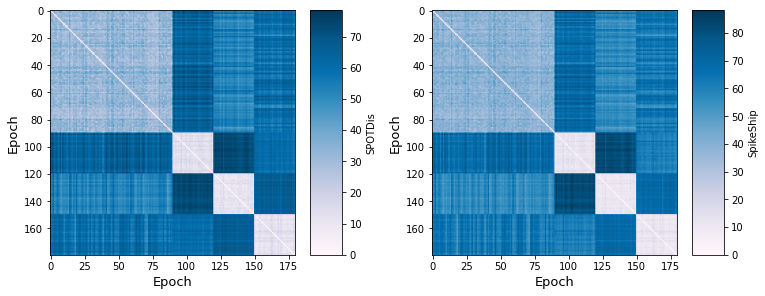

In [5]:
plt.clf()
alpha = 0.5; marker = 'o';
tPlot,axes = plt.subplots(
    figsize=(10.5,4), facecolor='w',nrows=1, ncols=2, sharex=False, sharey=False, constrained_layout=True)

# true labels sorting
si = np.argsort(epoch_labels)
print ("epoch_labels shape:", si.shape)

# dissimilarity matrices (vis)
im0 = axes[0].imshow(spot_dissimilarities[:, si][si], cmap='PuBu')

axes[0].set_xlabel('Epoch',fontsize=13); axes[0].set_ylabel('Epoch',fontsize=13);
plt.colorbar(im0, ax=axes[0], label='SPOTDis')

im1 = axes[1].imshow(ss_dissimilarities[:, si][si], cmap='PuBu')

axes[1].set_xlabel('Epoch',fontsize=13); axes[1].set_ylabel('Epoch',fontsize=13);
_ = plt.colorbar(im1, ax=axes[1], label='SpikeShip')

In order to compute these dissimilarity matrices, SPOTDis has a computational complexity of $\mathcal{O}(M^2N^2n^2)$, where $M$ is the number of epochs or trials, $N$ is the number of active Neurons, and $n$ the average spikes per epoch. In contrast, SpikeShip has a computational complexity of $\mathcal{O}(M^2 N n)$ (Quadratic speed-up).

---

### Visualization of clusters by using SPOTDis and SpikeShip dissimilarity measures

In [6]:
# to install sklearn run:
# ! conda install -c anaconda scikit-learn==0.22.1

In [7]:
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import hdbscan
from sklearn.manifold import TSNE

In [8]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
spot_labels = clusterer.fit_predict(spot_dissimilarities)


clusterer = hdbscan.HDBSCAN(metric='precomputed')
ss_dis_labels = clusterer.fit_predict(ss_dissimilarities)

print(len(np.unique(spot_labels)), 'clusters found (SPOTDis)')
print(len(np.unique(ss_dis_labels)), 'clusters found (SpikeShip, neuron-specific flows)')

4 clusters found (SPOTDis)
4 clusters found (SpikeShip, neuron-specific flows)


In [9]:
spot_embedding = TSNE(metric='precomputed', n_components=2).fit_transform(spot_dissimilarities)
ss_embedding   = TSNE(metric='precomputed', n_components=2).fit_transform(ss_dissimilarities)

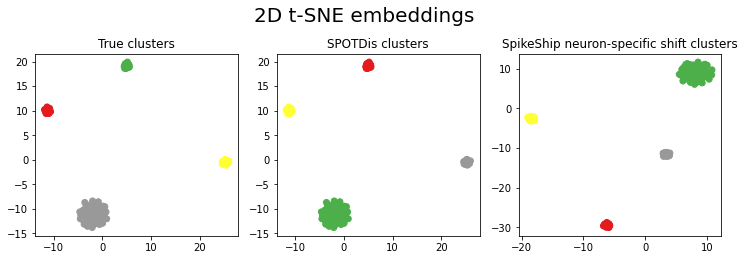

In [10]:
tPlot,axes = plt.subplots(
    figsize=(10,3.5), facecolor='w',nrows=1, ncols=3, sharex=False, sharey=False, constrained_layout=True)

plt.suptitle('2D t-SNE embeddings',fontsize=20)
axes[0].set_title('True clusters')
axes[0].scatter(spot_embedding[:, 0], spot_embedding[:, 1], cmap='Set1_r', c=epoch_labels)

axes[1].set_title('SPOTDis clusters')
axes[1].scatter(spot_embedding[:, 0], spot_embedding[:, 1], cmap='Set1_r', c=spot_labels)

axes[2].set_title('SpikeShip neuron-specific shift clusters')
axes[2].scatter(ss_embedding[:, 0], ss_embedding[:, 1], cmap='Set1_r', c=ss_dis_labels);


---
Check out our paper for more details:

Sotomayor-Gómez, B., Battaglia, F. P., & Vinck, M. (2021). [SpikeShip: A method for fast, unsupervised discovery of high-dimensional neural spiking patterns](https://doi.org/10.1101/2020.06.03.131573). *bioRxiv*.